# Module 2: Run Protein Structure Design and Protein Structure Prediction


NOTE: The authors recommend running this notebook in Amazon SageMaker Studio with the following environment settings:  
* **PyTorch 1.13 Python 3.9 GPU-optimized** image  
* **Python 3** kernel  
* **ml.g4dn.xlarge** instance type  

---

Analyzing large macromolecules like proteins is an essential part of designing new therapeutics. Recently, a number of deep-learning based approaches have improved the speed and accuracy of protein structure analysis. Some of these methods are shown in the image below.

![A diagram of common protein structure design steps](img/01.png)

In this module, we will use several AI algorithms to scaffold the RSV-F site 5 (which is one of the benchmarking examples from the RFDiffusion manuscript, and can be found in the github repository for diffusion). The steps for the pipeline are as follows:

* [RFDiffusion](https://github.com/RosettaCommons/RFdiffusion) is used to generate a small number of functional site scaffolds.

* [ProteinMPNN](https://github.com/dauparas/ProteinMPNN) is then used to discover novel sequences that are expected to fold to the novel structure. We will fix the residues associated with the functional site and allow everything else to be designed.

* [ESMFold](https://github.com/facebookresearch/esm) is then used to score each of the candidate proteins. ESMFold returns the average predicted local distance difference test (pLDDT) score; which represents the confidence (averaged over all residues) in the predicted structure. This will be used to assess whether the predicted structure is likely to be correct.

For running ESMFold, we will use the ESMFold endpoint deployed in Module 1, so please ensure that you have run that module **before** running this one.

---
## 1. Setup and installation

Install RFDiffusion and it's dependencies

In [16]:
%pip install -U -q -r protein-design-requirements.txt --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Download and extract the RFDiffusion and ProteinMPNN model weights (This will take several minutes)

In [3]:
%%bash
mkdir -p "data/weights/rfdiffusion" "data/weights/proteinmpnn" 
aws s3 cp --no-sign-request "s3://aws-batch-architecture-for-alphafold-public-artifacts/compressed/rfdiffusion_parameters_220407.tar.gz" "weights.tar.gz"
tar --extract -z --file="weights.tar.gz" --directory="data/weights/rfdiffusion" --no-same-owner
rm "weights.tar.gz"
wget -q -P "data/weights/proteinmpnn" https://github.com/dauparas/ProteinMPNN/raw/main/vanilla_model_weights/v_48_020.pt
wget -q -P "data" https://files.rcsb.org/download/5TPN.pdb 

download: s3://aws-batch-architecture-for-alphafold-public-artifacts/compressed/rfdiffusion_parameters_220407.tar.gz to ./weights.tar.gz


---
## 2. Generate RSV-F Site 5 scaffolds with RFdiffusion
First we will run RFdiffusion to generate some novel protein structures. To do this, we give the model a starting structure and tell it which which parts to change. We want to scaffold the RSV-F site 5, which means that diffusion should then build new protein backbone around it. We will focus on residues 163-181. 

*N.B. The structure 5TNP we are using is actually one subunit of the RSV-F trimer in complex with human antibody hRSV90*


In [11]:
import py3Dmol

view = py3Dmol.view(width=600, height=400)
with open("data/5TPN.pdb") as ifile:
    experimental_structure = "".join([x for x in ifile])
view.addModel(experimental_structure)
view.setStyle({"chain": "A"}, {"cartoon": {"color": "blue", "opacity": 0.4}})
view.addStyle(
    {"chain": "A", "resi": "163-181"}, {"cartoon": {"color": "#57C4F8", "opacity": 1.0}}
)
view.setStyle({"chain": ["H",'L']}, {"cartoon": {"color": "yellow", "opacity": 0.4}}) # this is our Ab
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Here are our design constraints:

- Look at residues 163-181 of the target molecule (green structure in image above)
- Create a new structure that includes residues 163-181 of RSV-F.
- Diffuse an additional 40 residues off both the N- and C-termini off the site we're scaffolding.
- Create 10 designs in total.
- Leave the rest of the RFdiffusion parameters as the default values

In [9]:
%%time
!mkdir -p data/results/rfdiffusion

from prothelpers.rfdiffusion import create_structures

create_structures(
    overrides=[
        "inference.input_pdb=data/5TPN.pdb",
        "inference.output_prefix=data/results/rfdiffusion/rfdiffusion_result",
        "inference.model_directory_path=data/weights/rfdiffusion",
        "contigmap.contigs=[40/A163-181/40]",
        "inference.num_designs=2",
    ]
)

Reading models from data/weights/rfdiffusion
This is inf_conf.ckpt_path
data/weights/rfdiffusion/Base_ckpt.pt
Assembling -model, -diffuser and -preprocess configs from checkpoint
USING MODEL CONFIG: self._conf[model][n_extra_block] = 4
USING MODEL CONFIG: self._conf[model][n_main_block] = 32
USING MODEL CONFIG: self._conf[model][n_ref_block] = 4
USING MODEL CONFIG: self._conf[model][d_msa] = 256
USING MODEL CONFIG: self._conf[model][d_msa_full] = 64
USING MODEL CONFIG: self._conf[model][d_pair] = 128
USING MODEL CONFIG: self._conf[model][d_templ] = 64
USING MODEL CONFIG: self._conf[model][n_head_msa] = 8
USING MODEL CONFIG: self._conf[model][n_head_pair] = 4
USING MODEL CONFIG: self._conf[model][n_head_templ] = 4
USING MODEL CONFIG: self._conf[model][d_hidden] = 32
USING MODEL CONFIG: self._conf[model][d_hidden_templ] = 32
USING MODEL CONFIG: self._conf[model][p_drop] = 0.15
USING MODEL CONFIG: self._conf[model][SE3_param_full] = {'num_layers': 1, 'num_channels': 32, 'num_degrees': 2, 

Our new designs are in the `data/results/rfdiffusion` folder. Let's take a look at them. We have our motif highlighted in blue, and then the newly diffused residues are shown in light grey.

In [13]:
from prothelpers.structure import extract_structures_from_dir, create_tiled_py3dmol_view

rfdiffusion_results_dir = "data/results/rfdiffusion"
structures = extract_structures_from_dir(rfdiffusion_results_dir)

view = create_tiled_py3dmol_view(structures, total_cols=2)

view.setStyle({"chain": "A"}, {"cartoon": {"color": "#e0e0e0", "opacity": 1.0}})
view.addStyle(
    {"chain": "A", "resi": "41-59"}, {"cartoon": {"color": "blue", "opacity": 1.0}}
)


view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3. Translate Structure into Sequence with ProteinMPNN
ProteinMPNN is a tool for **inverse protein folding**. In inverse protein folding, the input is a protien tertiary structure, while the output is a sequence (or sequences) that are predicted to fold in the specified structure. Here is a schematic for how it works:
<div style="text-align: left;">
    <img src="img/06.png" alt="A diagram of inverse protein folding" width="700" />
</div>
                        
*image credit: https://huggingface.co/spaces/simonduerr/ProteinMPNN.*        
                               
ProteinMPNN will returns the sequences in [FASTA format](https://software.broadinstitute.org/software/igv/FASTA). 

We gather the locations of the RFDiffusion output structures and submit them to ProteinMPNN. This will take about 15 seconds on a ml.g4dn.xlarge instance.

**BUT:** We just scaffolded a functional site that we want to preserve (i.e. do not want to change!). Therefore, we must also tell MPNN to *fix* specific residues. We can do this by generating a dictionary (`.jsonl` file) that indicates which postions are fixed. We can get this information from the contigs we feed into diffusion and quickly write it up. 

In [39]:
residues_to_fix = [i for i in range(41,60)] # <-- THIS IS BASED OFF OF OUR CONTIGS IN DIFFUSION

In [40]:
%%time
!mkdir -p data/results/proteinmpnn
!mkdir -p data/results/proteinmpnn/input_files

from prothelpers import proteinmpnn
from prothelpers.sequence import list_files_in_dir
from prothelpers.proteinmpnn_helpers import write_fixed_positions_jsonl_single_chain

rfdiffusion_candidates = list_files_in_dir(rfdiffusion_results_dir, extension=".pdb")

proteinmpnn_results_dir = "data/results/proteinmpnn"
proteinmpnn_inputfiles_dir = 'data/results/proteinmpnn/input_files'

for path in rfdiffusion_candidates:
    # make fixed jsonl input file, function returns file path
    jsonl_path_fixed = write_fixed_positions_jsonl_single_chain(pdb=path,
                                                                residues_to_fix=residues_to_fix,
                                                                outfolder=proteinmpnn_inputfiles_dir)
    proteinmpnn.design(
        pdb_path=path,
        out_folder=proteinmpnn_results_dir,
        num_seq_per_target=4,
        fixed_positions_jsonl=f'{jsonl_path_fixed}',
        path_to_model_weights="data/weights/proteinmpnn",
        batch_size=1,
        suppress_print=1,
    )

CPU times: user 2.62 s, sys: 167 ms, total: 2.79 s
Wall time: 3.98 s


Let's look at the results

In [35]:
import os
from prothelpers.sequence import extract_seqs_from_dir

mpnn_dir = os.path.join(proteinmpnn_results_dir, "seqs")
mpnn_sequences = extract_seqs_from_dir(mpnn_dir, extension="fa")
print(mpnn_sequences)

['GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGEVNKIKSALLSTNKAVVSLGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG', 'KKVKKVLLSGSKELLKDFLDYLEEAIKKGSPSIAGKLTPEEVNKIKSALLSTNKAVVSLSVEAAEAFVKAVEEFSEEREKKYGWPRIKVEVDPEVTEIK', 'KKVKEVYLSGTKEQLDLFLKYLEKDIKEKKNSIAGKLSLEEVNKIKSALLSTNKAVVSLSVESAENFVKAVKEFSEKQKKEKGLPEIKVKVSPKITEIK', 'KKVVNVKISGSKEQLEAFLNDLEKAIEEGSPSIAGKLSKEEVNKIKSALLSTNKAVVSLSPESAKNFVEAAKAFSKEQKEKYGWPEIKVEVDKEIKEIK', 'KKVKNVLLSGSKELLDEFLDYLEEAIKKGEPSIAGKLSLEEVNKIKSALLSTNKAVVSLSVESAEAFKKAAEEFSEKQEKEKGKPRIKVEVDPEVTTIE', 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGEVNKIKSALLSTNKAVVSLGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG', 'KLLPPKVFKAEFTISEDGTITVVKCDDEEMKKILESLTKEEVNKIKSALLSTNKAVVSLIDKETGSVYTLLLSAEEVTTSSGKKLTKVTGTVTRTKILK', 'KLLPPKVFKAEFRISEDGTIEVISCDDEEMKKLLESLTKEEVNKIKSALLSTNKAVVSLERKETGEKYTLKLEAEEETDASGKKYLKVTATVTRTKKLK', 'ELLPEKVFNVKFEISEDGKITVLSCDDEEMKKILESLTKEEVNKIKSALLSTNKAVVSLVDEETGEEYTLELESKKKTTKEGKEVLLVTGTVTRKKRLK', 'RLLPPVVFNVKFTISEDGTITVEECEDEEMREYLESLTKEEVNKIKSALLSTNKAVVSLVDPETGSELVLE

## Run Inference on ESMFold

ProteinMPNN has generated 16 new sequences, 4 per predicted structure. But which one should we test in the lab? There are lots of metrics we could use, like isoelectric point, patent status, or homology with other sequences. For this example, we're going to measure the "foldability" of each sequence using ESMFold. This is a popular way to identify those sequences that are most similar to other experimentally-determined structures. Specifically, we'll use the average predicted local distance difference test (pLDDT) score, a measure of the ESMFold prediction confidence.

** NOTE: STOP HERE if you have not finished deploying the ESMFold prediction endpoint from module 1.**

In [36]:
%store -r endpoint_name

In [38]:
import boto3

# Wait until ESMFold endpoint from module 1 is in service
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

WaiterError: Waiter EndpointInService failed: Waiter encountered a terminal failure state: Matched expected service error code: ValidationException

In [ ]:
%%time
!mkdir -p data/results/esmfold

import json
from prothelpers.structure import get_mean_plddt
import pandas as pd
import sagemaker
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker.Session(),
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.StringDeserializer(),
)

metrics = []
for i, seq in enumerate(mpnn_sequences):
    print(f"Generating structure prediction {i} for {seq}")
    esmfold_output = json.loads(predictor.predict(seq))[0]
    mean_plddt = get_mean_plddt(esmfold_output)
    output_file = f"data/results/esmfold/prediction_{i}.pdb"
    with open(output_file, "w") as f:
        f.write(esmfold_output)
    metrics.append(
        {"seq": seq, "esmfold_result": output_file, "mean_plddt": mean_plddt}
    )

metrics_df = (
    pd.DataFrame(metrics)
    .sort_values(by="mean_plddt", ascending=False)
    .reset_index(drop=True)
)
metrics_df

You can see from the results above that the designed proteins have a PLDDT of 0.8 or greater, meaning that ESMFold has high confidence in the structures. The highest-scoring sequences are good candidates for synthesis and testing.

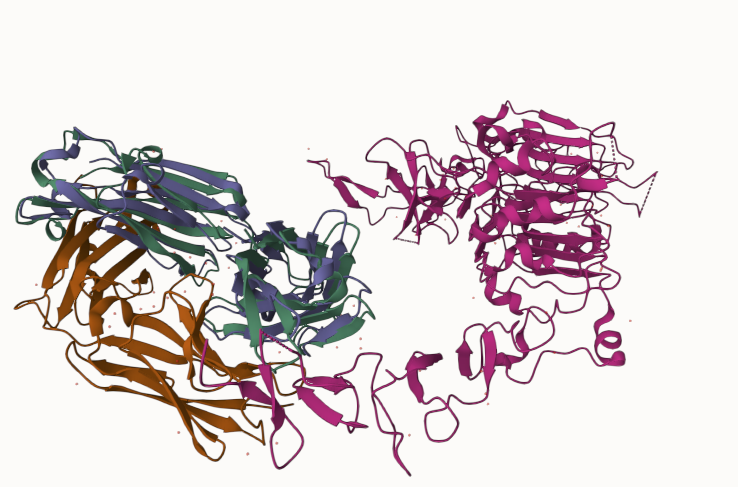Here is a screenshot of one example of the designed antibody (blue) superimposed on the orignal antibody (green). The orange and red corresponds to the extracellular domain of HER2. Note that the structure of the designed antibody is similair, but not identical to the original.

![Picture of designed protein](img/03.png)


When you are finished with this module, uncomment and run the cell below to delete the ESMFold endpoint.

In [ ]:
%store -z

try:
    predictor.delete_endpoint()
except:
    pass